In [ ]:
install.packages("stats")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘stats’ is a base package, and should not be updated”


In [ ]:
install.packages("deSolve")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(stats)

In [ ]:
library(deSolve)

In [ ]:
#Function to define the SIR model
SIR_model <- function(time, state, parms) {
  with(as.list(c(state, parms)), {
    dy <- c(
      -b * S * I,
      b * S * I - a * I,
      a * I
    )
    return(list(dy))
  })
}

In [ ]:
error_in_data <- function(params, tdata, qdata) {
  t_forward <- seq(from = 3, to = 14, by = 0.01)
  t_measure <- seq(from = 1, to = 1101, by = 100)[1:length(tdata)]

  # Solving the differential equation with current parameters
  solution <- ode(y = c(S = 738.0, I = 25.0, R = 0), t = t_forward,
                  func = SIR_model, parms = params)

  # Extracting predicted values at data points
  predicted_y <- solution[t_measure, "I"]

  # Calculating SSE
  error <- sum((predicted_y - qdata)^2)
  return(error)
}

In [ ]:
 #Load data
data <- read.csv("SIRdata.csv")
tdata <- data[, 1]
qdata <- data[, 2]

# Initial guess for parameters
params <- c(a = 0, b = 0.0025)

In [ ]:
nelder_mead <- function(func, x0, max_iter = 100, tol = 1e-8) {

  n <- length(x0)  # D-number
  simplex <- matrix(rep(x0, n + 1), nrow = n + 1, ncol = n)
  fval <- sapply(simplex, func)  # Evaluate function at simplex points
  order <- order(fval)  # Sort by function value (ascending)

  for (iter in 1:max_iter) {
    # Centroid (excluding worst point)
    centroid <- colMeans(simplex[order[1:(n + 1)], ])

    # Reflection
    reflected <- centroid + (1.0 + rnorm(n)) * (centroid - simplex[order[n + 1], ])
    f_reflected <- func(reflected)

    # Check if reflection is better than worst
    if (f_reflected < fval[order[n + 1]]) {
      simplex[order[n + 1], ] <- reflected
      fval[order[n + 1]] <- f_reflected
      continue
    }

    # Expansion (if reflection is not good enough)
    if (f_reflected >= fval[order[n]]) {
      expanded <- centroid + (3.0 * (centroid - simplex[order[n + 1], ]))
      f_expanded <- func(expanded)
      if (f_expanded < fval[order[n + 1]]) {
        simplex[order[n + 1], ] <- expanded
        fval[order[n + 1]] <- f_expanded
      } else {
        # Contraction (both reflection and expansion failed)
        for (i in 2:(n + 1)) {
          simplex[order[i], ] <- (1.0 - rnorm(n)) * simplex[order[0], ] + rnorm(n) * simplex[order[i], ]
          fval[i] <- func(simplex[order[i], ])
        }
      }
    } else {
      # Shrink (all attempts failed, shrink simplex towards best)
      for (i in 2:(n + 1)) {
        simplex[order[i], ] <- (1.0 - rnorm(n)) * simplex[order[0], ] + rnorm(n) * simplex[order[i], ]
        fval[i] <- func(simplex[order[i], ])
      }
    }

    # Check for convergence (maximum diameter of simplex)
    if (max(diag(var(simplex))) < tol) {
      break
    }
  }

  return(list(x = simplex[order[1], ], fval = fval[order[1]], iter = iter))
}




In [ ]:
# Minimize the error using Nelder-Mead simplex method
optimized_params <- optim(params, fn = error_in_data, tdata = tdata, qdata = qdata,
                          method = "Nelder-Mead")

In [ ]:
solution <- ode(y = c(S = 738.0, I = 25.0, R = 0), t = tdata,
                func = SIR_model, parms = optimized_params$par)

In [ ]:
#Final optimized parameters
cat("Optimized parameters:\n")
print(optimized_params$par)

Optimized parameters:
         a          b 
0.46477840 0.00237843 


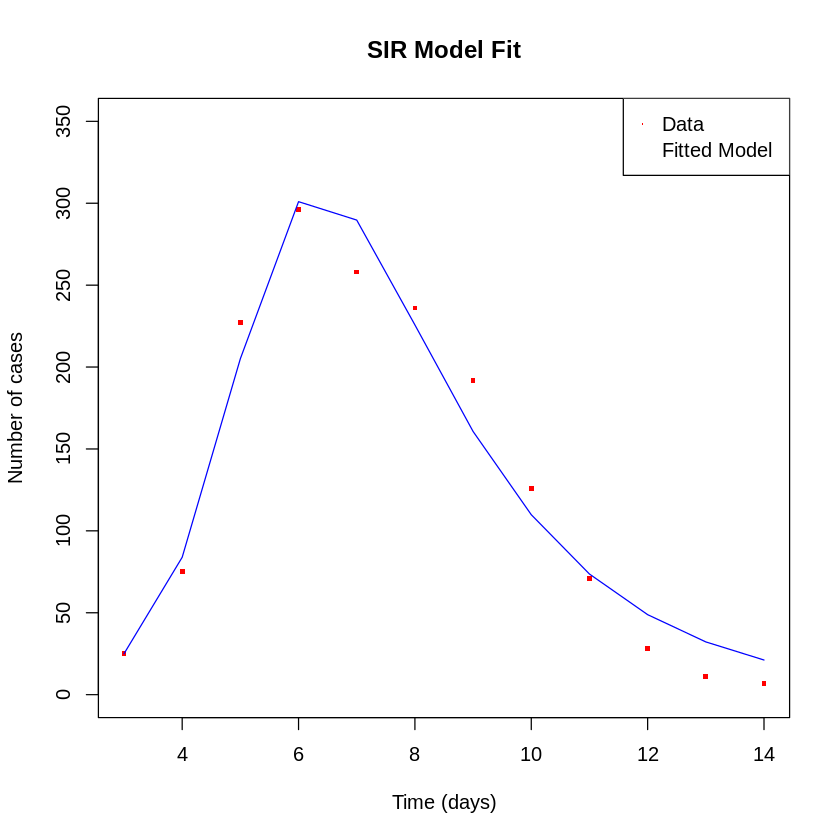

In [ ]:
plot(tdata, qdata, col = "red", pch = ".", cex = 4,  # Increase dot size with 'cex'
     xlab = "Time (days)", ylab = "Number of cases",
     xlim = c(3, 14), ylim = c(0, 350))
lines(solution[, "time"], solution[, "I"], col = "blue")
legend("topright", legend = c("Data", "Fitted Model"), col = c("red", "blue"), pch = c(".", NA))
title("SIR Model Fit")

In [ ]:
# Extract predicted values for all compartments
predicted_S <- solution[, "S"]
predicted_I <- solution[, "I"]
predicted_R <- solution[, "R"]

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"label" is not a graphical parameter”
Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"label" is not a graphical parameter”
Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"label" is not a graphical parameter”


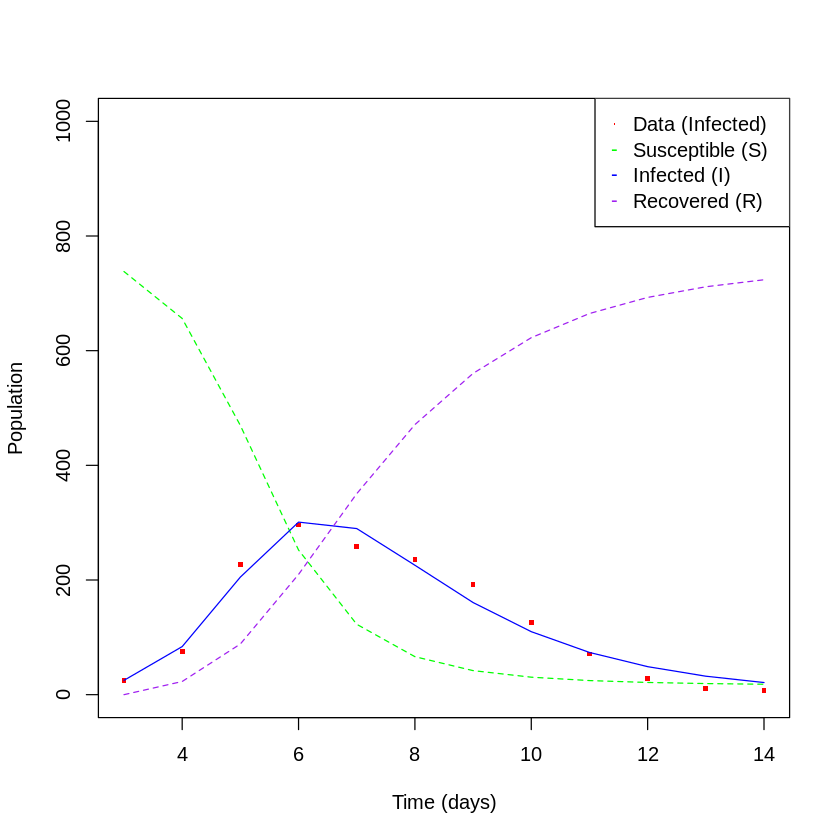

In [ ]:

plot(tdata, qdata, col = "red", pch = ".", cex = 4, xlab = "Time (days)", ylab = "Population",
     ylim = c(0, 1000))  # Set y-axis limits

# Overlay prediction lines with labels
lines(solution[, "time"], predicted_S, col = "green", lty = "dashed",
      label = "Susceptible (S)")  # Add label for green line
lines(solution[, "time"], predicted_I, col = "blue", label = "Infected (I)")  # Add label for blue line
lines(solution[, "time"], predicted_R, col = "purple", lty = "dashed",
      label = "Recovered (R)")  # Add label for purple line

# Add legend
legend("topright", legend = c("Data (Infected)", "Susceptible (S)",
                              "Infected (I)", "Recovered (R)"),
       col = c("red", "green", "blue", "purple"), pch = c(".", "-", "-", "--"))

